In [98]:
import os
from datetime import datetime
from pprint import pprint
from typing import List
import string
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
import app
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from shapely.geometry import Point

# 0. Import

In [99]:
data_folder = r"D:\[Code]\HydrofractureShackleton_2023\data"
data_dmg_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-dmg"
data_img_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-img"
figure_folder = r"D:\[Code]\HydrofractureShackleton_2023\figures"

In [100]:
path = os.path.join(data_folder, r"shackleton_hydrofractures.xlsx")
events_raw = pd.read_excel(path, index_col=0)
events_raw["geometry"] = gpd.GeoSeries.from_wkt(events_raw["geometry"])
events = gpd.GeoDataFrame(events_raw, geometry="geometry")  # type: ignore
events.set_crs("EPSG:4326", inplace=True)
events.sort_values("lon", inplace=True)
events.reset_index(drop=True, inplace=True)
events.to_crs("EPSG:3031", inplace=True)
events["label"] = list(string.ascii_uppercase)[: len(events)]
events["summer"] = [app.determine_antarctic_summer(d) for d in events["date-0 vis"]]
events["volume-1 m^3"] = np.nan_to_num(x=events["volume-1 m^3"].values, nan=0) # type: ignore

In [101]:
optical_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Optical"
]
sar_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Draining"
]

In [108]:
keys = ["lat", "lon", "Timestamp", "satellite", "file"]
metas = []
for f in optical_files:

    meta_info = f.split("_")[6:9] + [f.split("_")[9].split(".")[0]]
    meta_info[0] = float(meta_info[0])  # type: ignore
    meta_info[1] = float(meta_info[1])  # type: ignore
    meta_info[2] = pd.Timestamp(int(meta_info[2]), unit="ms")  # type: ignore
    meta_info.append(f)
    meta = {k: v for k, v in zip(keys, meta_info)}
    metas.append(meta)
optical = pd.DataFrame(metas)
optical["geometry"] = optical.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
optical = gpd.GeoDataFrame(optical, geometry="geometry") # type: ignore
optical.set_crs("EPSG:4326", inplace=True)
optical.to_crs("EPSG:3031", inplace=True)
optical.sort_values("lon", inplace=True)
optical.reset_index(drop=True, inplace=True)
optical["lat round"] = optical["lat"].round(2)

temp_events = events.copy()
temp_events["lat round"] = events["lat"].round(2)
print()
optical = pd.merge(
    optical, temp_events, left_on="lat round", right_on="lat round", how="left"
)
optical.sort_values("label", inplace=True)
print(optical.label.unique())
optical.columns


['A' 'B' 'C' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q']


Index(['lat_x', 'lon_x', 'Timestamp', 'satellite', 'file', 'geometry_x',
       'lat round', 'lon_y', 'lat_y', 'lake', 'tile', 'date-0', 'sat-0',
       'start-0', 'end-0', 'meandepth-0 m', 'volume-0 m^3', 'sat-0 vis',
       'date-0 vis', 'date-1', 'sat-1', 'start-1', 'end-1', 'meandepth-1 m',
       'volume-1 m^3', 'sat-1 vis', 'date-1 vis', 'comment', 'geometry_y',
       'type', 'label', 'summer'],
      dtype='object')

In [94]:
tides = app.load_tide_files(
    [
        os.path.join(data_folder, f)
        for f in os.listdir(data_folder)
        if "tides" in f.lower()
    ]
)

In [109]:
tides["plotting_date"] = tides["date"]
for i_summer, summer in enumerate(tides.summer.unique()):
    tides.loc[tides.summer == summer, "plotting_date"] = tides["date"] + pd.DateOffset(years=2020 - summer)


for i_summer, summer in enumerate(tides.summer.unique()):
    drains_summer = events.query("summer == @summer")
    tides_summer = tides.query("summer == @summer")

    date_list = pd.Series(tides_summer.date).dt.date.tolist()

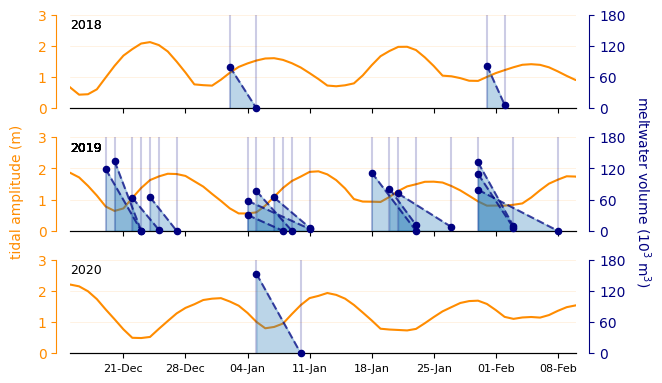

In [110]:
from dateutil.rrule import MO
ymin = 0
ymax = 3
ymax_volume = 180

color_tide = "darkorange"
color_water = "navy"

fig, axes = plt.subplots(3, 1, figsize=(17 / 2.54, 10 / 2.54), sharex=True)
for i_summer, summer in enumerate(tides.summer.unique()):

    evnets_summer = events.query("summer == @summer").copy()
    tides_summer = tides.query("summer == @summer").copy()

    ax = axes.ravel()[i_summer]
    ax_ = ax.twinx()

    ax.plot(tides_summer.plotting_date, tides_summer.tide, color = color_tide, zorder = 1)

    for i_drain, (date0, date1, sat0, sat1, volume0, volume1) in enumerate(
        zip(
            evnets_summer["date-0 vis"],
            evnets_summer["date-1 vis"],
            evnets_summer["sat-0 vis"],
            evnets_summer["sat-1 vis"],
            evnets_summer["volume-0 m^3"],
            evnets_summer["volume-1 m^3"],
        )
    ):
        volume0 = volume0 / 1e3
        volume1 = volume1 / 1e3
        days = (date1 - date0).days
        height = volume0 / 5e4 / days

        values = app.interpolate_dates(
            tides_summer, "plotting_date", "tide",
            [
                (date0 + pd.DateOffset(years=2020 - summer)).strftime("%Y-%m-%d"),
                (date1 + pd.DateOffset(years=2020 - summer)).strftime("%Y-%m-%d"),
            ],
        )
        ax_.plot(
            [date0 + pd.DateOffset(years=2020 - summer), 
             date1 + pd.DateOffset(years=2020 - summer)],
            [volume0, volume1],
            color = color_water,
            ls = "--", alpha = 0.7, zorder = 10)

        ax_.scatter(
            date0 + pd.DateOffset(years=2020 - summer),
            volume0,
            color=color_water,
            zorder=10,
            s=20,
            clip_on=False,
        )
        ax_.scatter(
            date1 + pd.DateOffset(years=2020 - summer),
            volume1,
            color=color_water,
            zorder=10,
            s=20,
            clip_on=False,
        )

        ax_.fill_between(
            [date0 + pd.DateOffset(years=2020 - summer), date1 + pd.DateOffset(years=2020 - summer)],
            [0, 0],
            [volume0, volume1],
            color="tab:blue",
            alpha=0.3,
            zorder=1,
        )

        ax.text(x=0, y=0.96, s=summer, transform=ax.transAxes, ha="left", va="top", fontsize=9)

        ax.set_ylim(ymin, ymax)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
        ax.tick_params(axis="x", labelsize=8)
        ax.spines.left.set_position(("outward", 10))
        ax.spines.left.set_color(color_tide)
        ax.tick_params(axis="y", colors=color_tide)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.grid(alpha = 0.2, color = color_tide, zorder = 0, axis = "y", lw = 0.4)

        ax_.set_ylim(0, ymax_volume)
        ax_.yaxis.set_major_locator(ticker.MultipleLocator(60))
        ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
        ax_.spines.right.set_position(("outward", 10))
        ax_.spines.right.set_color(color_water)
        ax_.tick_params(axis="y", colors=color_water)
        ax_.spines.left.set_visible(False)
        ax_.spines.top.set_visible(False)
    for d in pd.concat([evnets_summer["date-0 vis"], evnets_summer["date-1 vis"]]).unique():
        ax_.axvline(
            d + pd.DateOffset(years=2020 - summer), ls="-", color=color_water, alpha=0.2, lw = 1.5, zorder = 2
        )

fig.text(0.02, 0.5, r"tidal amplitude (m)", ha="left", va="center", color=color_tide, rotation=90)
fig.text(
    0.98,
    0.5,
    r"meltwater volume ($10^3$ m$^3$)",
    ha="right",
    va="center",
    color=color_water,
    rotation=-90,
)

ax = axes.ravel()[0]
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.set_xlim([datetime(2020, 12, 15), datetime(2021, 2, 10)])

plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.865)
fig.savefig(os.path.join(figure_folder, "figure_03.pdf"), dpi=300)
plt.show()